### Set up

In [1]:
using_colab = False

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p videos
    !wget -P videos https://dl.fbaipublicfiles.com/segment_anything_2/assets/bedroom.zip
    !unzip -d videos videos/bedroom.zip

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

In [3]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import tempfile
import shutil
import matplotlib.pyplot as plt

In [4]:
import sys
# Add the parent directory to the Python path
sys.path.append(os.path.abspath('..'))  # or the full path to your project folder

In [5]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [6]:
from sam2.build_sam import build_sam2_video_predictor
sam2_checkpoint = "/home/rizo/mipt_ccm/sam2/sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [7]:
MODEL_TYPE = "sam2.1_hiera_tiny"

In [8]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.4])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))



In [9]:
frames_dark_1 = "/home/rizo/mipt_ccm/sam2_eval/custom_test/frames/_home_rizo_mipt_ccm_sam2_eval_custom_test_dark_1"
frames_dark_2 = "/home/rizo/mipt_ccm/sam2_eval/custom_test/frames/_home_rizo_mipt_ccm_sam2_eval_custom_test_dark_2"
frames_light_1 = "/home/rizo/mipt_ccm/sam2_eval/custom_test/frames/_home_rizo_mipt_ccm_sam2_eval_custom_test_light_1"
frames_light_2 = "/home/rizo/mipt_ccm/sam2_eval/custom_test/frames/_home_rizo_mipt_ccm_sam2_eval_custom_test_light_2"
frames_light_3 = "/home/rizo/mipt_ccm/sam2_eval/custom_test/frames/_home_rizo_mipt_ccm_sam2_eval_custom_test_light_3"
frames_light_4 = "/home/rizo/mipt_ccm/sam2_eval/custom_test/frames/_home_rizo_mipt_ccm_sam2_eval_custom_test_light_4"
frames_light_5 = "/home/rizo/mipt_ccm/sam2_eval/custom_test/frames/_home_rizo_mipt_ccm_sam2_eval_custom_test_light_5"
frames_short = "/home/rizo/mipt_ccm/sam2_eval/custom_test/frames/_home_rizo_mipt_ccm_sam2_eval_custom_test_short"
frames_card = "/home/rizo/mipt_ccm/sam2_eval/custom_test/frames/_home_rizo_mipt_ccm_sam2_eval_custom_test_card"

In [10]:
def show_annot_on_current_img(ann_frame_idx, video_dir, annotations, out_obj_ids, out_mask_logits, frame_names):
    # Show the results on the current frame
    plt.figure(figsize=(9, 6))
    plt.title(f"Frame {ann_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[int(ann_frame_idx)])))

    # Plot points for all objects
    for ann in annotations:
        ann_obj_id = ann["id"]
        points = np.array([[ann["x"], ann["y"]]], dtype=np.float32)
        labels = np.array([ann["prompt_type"]], dtype=np.int32)
        show_points(points, labels, plt.gca())

    # Plot masks for all objects
    for i, out_obj_id in enumerate(out_obj_ids):
        show_mask((out_mask_logits[i] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_id)

In [11]:
def feed_promt(video_dir, annot, predictor, inference_state, frame_names):
    """
    Process frames with annotations from annot using SAM 2 predictor and visualize results.

    Args:
        video_dir (str): Directory containing JPEG frames (e.g., '00000.jpg').
        annot (dict): Dictionary with frame indices and point annotations.
        predictor: SAM 2 video predictor instance.
        inference_state: Initialized SAM 2 inference state.
    """
     # choose a qualitative colormap for up to 20 distinct IDs
    cmap = plt.cm.get_cmap('tab20')
    
    # Process each annotated frame
    for ann_frame_idx in sorted(annot.keys()):

        # Get annotations for this frame
        annotations = annot[ann_frame_idx]

        # Collect points and labels for all objects in this frame
        for ann in annotations:
            ann_obj_id = ann["id"]  # Use id as object ID
            points = np.array([[ann["x"], ann["y"]]], dtype=np.float32)
            labels = np.array([ann["prompt_type"]], dtype=np.int32)

            # Add points to SAM 2 predictor
            _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
                inference_state=inference_state,
                frame_idx=int(ann_frame_idx),
                obj_id=ann_obj_id,
                points=points,
                labels=labels,
            )
        
        # run propagation throughout the video and collect the results in a dict
        video_segments = {}  # video_segments contains the per-frame segmentation results
        for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
            video_segments[out_frame_idx] = {
                out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
                for i, out_obj_id in enumerate(out_obj_ids)
            }
            # frame_data = {}
            # for i, out_obj_id in enumerate(out_obj_ids):
            #     mask = (out_mask_logits[i] > 0.0).cpu().numpy()  # (H, W) boolean array

            #     mask2 = np.squeeze(mask)  # Removes extra dimensions like (1, H, W) -> (H, W)
                
            #     # Find points inside the mask
            #     ys, xs = np.where(mask2)

            #     if len(xs) > 0:
            #         # Randomly pick one point from inside the mask
            #         idx = np.random.choice(len(xs))
            #         sample_point = (int(xs[idx]), int(ys[idx]))  # (x, y) coordinate
            #     else:
            #         sample_point = None  # Mask is empty (should rarely happen)

            #     frame_data[out_obj_id] = {
            #         'mask': mask,
            #         'sample_point': sample_point,
            #     }
            
            # video_segments[out_frame_idx] = frame_data

        # Load the annotated frame
        img_path = os.path.join(video_dir, frame_names[int(ann_frame_idx)])
        img = plt.imread(img_path)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax.imshow(img)
        ax.set_title(f"Frame {ann_frame_idx}")
        ax.axis('off')

        # Overlay each object mask without text
        for obj_id, mask in video_segments.get(ann_frame_idx, {}).items():
            m = np.squeeze(mask).astype(bool)
            if not m.any():
                continue

            color = cmap(obj_id % 20)  # select color
            ax.imshow(np.ma.masked_where(~m, np.ones_like(m)),
                      cmap=plt.cm.get_cmap('tab20')(obj_id % 20),
                      alpha=0.5)

        # plt.show()
        
        save_dir = "promps/visualization"  

        # Save the figure
        save_path = os.path.join(save_dir, f"frame_{int(ann_frame_idx):04d}.png")
        plt.savefig(save_path, bbox_inches='tight')
        plt.close(fig)  # Close figure to save memory
        
        return video_segments

In [12]:
palette = {
    2: (255, 0, 0),     # Red
    1: (0, 255, 0),     # Green
    0: (0, 0, 255),     # Blue
    3: (255, 255, 0),   # Yellow
    4: (0, 255, 255),   # Cyan
    5: (255, 0, 255),   # Magenta
    6: (255, 127, 0),   # Orange
    7: (127, 0, 255),   # Purple
}

In [14]:
def create_video_with_masks(video_dir, frame_names, video_segments, output_video_path):
    """
    Create a video with masks overlayed on the original frames.

    Args:
        video_dir (str): Directory containing frames.
        frame_names (list): List of frame filenames.
        video_segments (dict): Segmentation results for each frame.
        output_video_path (str): Path to save the output video.
        vis_frame_stride (int): Frame stride for visualization.
        frame_size (tuple): Size of the video frames (width, height).
    """

    # Set up the video writer (codec for video writing, frame size, and frames per second)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for .mp4 file
    fps = 30  # Frames per second for the video
    out_video = cv2.VideoWriter(output_video_path, fourcc, fps, frameSize=(1920, 1080))

    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 2
    font_color = (255, 255, 255)  # White
    font_thickness = 2
    text_position = (50, 80)  # (x, y) position for model name
    
    # Loop through the frames and overlay the segmentation masks
    for out_frame_idx in range(0, len(frame_names)):
        # print(f"Processing frame {out_frame_idx}...")
        # Load the original frame
        frame_path = os.path.join(video_dir, frame_names[out_frame_idx])
        frame = cv2.imread(frame_path)  # Read the image as a frame
        
        # Ensure the frame is the correct size (resize if necessary)
        frame_resized = frame

        # Initialize the mask overlay (all black initially)
        mask_overlay = np.zeros_like(frame_resized)

        # Apply the masks for each object in the frame
        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            # Ensure that the mask is a 2D boolean array
            
            if isinstance(out_mask, np.ndarray):
                # Squeeze the mask to ensure correct shape: (1, 1080, 1920) -> (1080, 1920)
                mask = np.squeeze(out_mask)

                # Ensure mask is binary (0 or 255)
                mask = np.uint8(mask * 255)  # Convert to a binary mask

                # Create a colored mask (e.g., red) and overlay it on the original frame
                mask_color = np.zeros_like(frame_resized)
                mask_color[mask > 0] = palette[out_obj_id]

                # Blend the mask with the original frame
                blended_frame = cv2.addWeighted(frame_resized, 1.0, mask_color, 0.5, 0)
                
                # Replace original frame with blended one
                frame_resized = blended_frame
            else:
                print(f"Warning: Skipping mask for obj_id {out_obj_id} because it's not a valid numpy array")

        # Add the MODEL_NAME text at the top
        frame_with_text = frame_resized.copy()
        cv2.putText(frame_with_text, MODEL_TYPE, text_position, font, font_scale, font_color, font_thickness, lineType=cv2.LINE_AA)

        # Write the frame with the mask to the video
        out_video.write(frame_with_text)

    # Release the video writer
    out_video.release()
    print(f"Video saved to {output_video_path}")

### dark 1

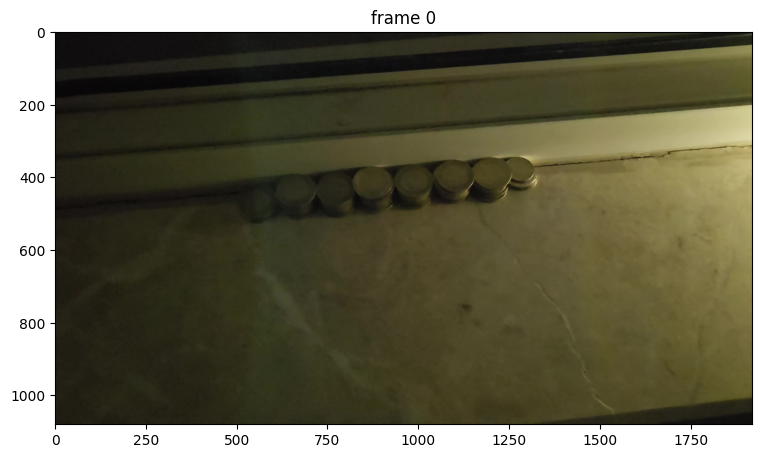

In [22]:
# scan all the JPEG frame names in this directory
frame_names_dark_1 = [
    p for p in os.listdir(frames_dark_1)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names_dark_1.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(frames_dark_1, frame_names_dark_1[frame_idx])))

In [ ]:
from utils.annotations import dark_1_annot

In [ ]:
inference_state_dark_1 = predictor.init_state(video_path=frames_dark_1)

frame loading (JPEG): 100%|██████████| 274/274 [00:12<00:00, 21.38it/s]


/home/rizo/mipt_ccm/sam2/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/home/rizo/mipt_ccm/sam2/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


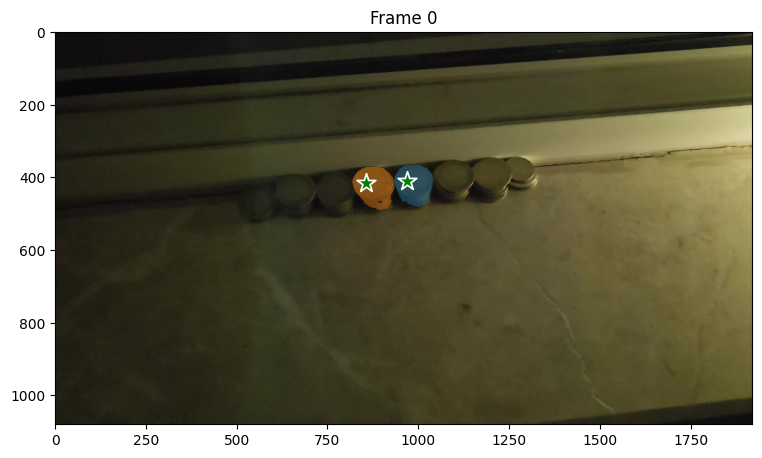

propagate in video: 100%|██████████| 274/274 [03:06<00:00,  1.47it/s]


In [ ]:
video_segments_dark_1 = feed_promt(frames_dark_1, dark_1_annot, predictor, inference_state_dark_1, frame_names_dark_1)

#### Visualisation of some annotated frames

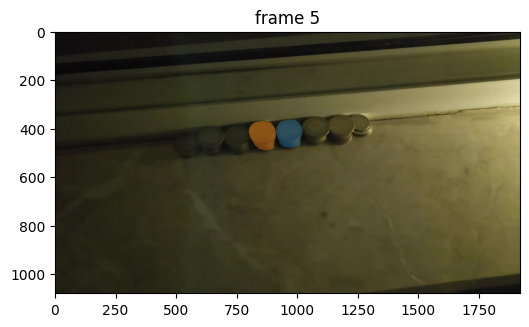

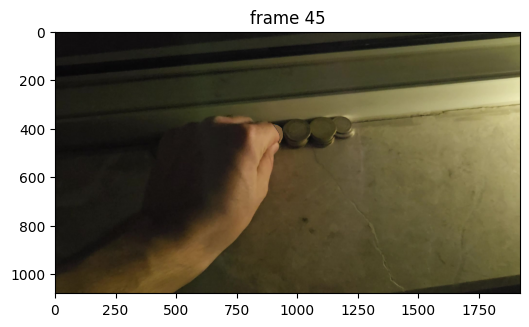

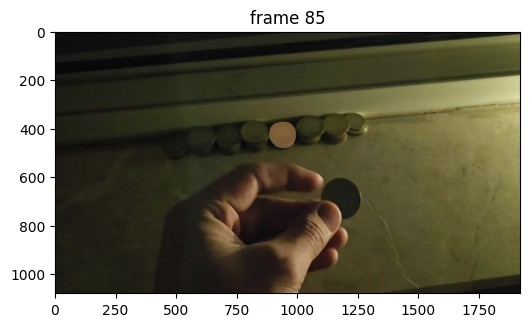

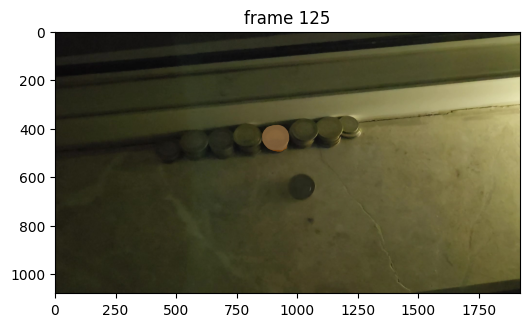

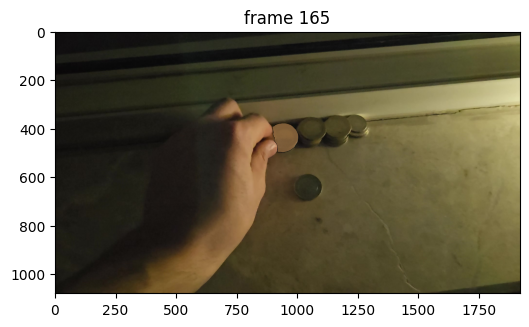

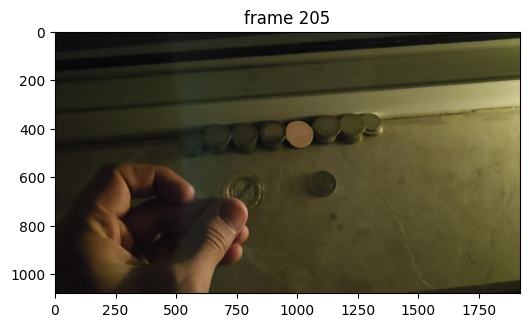

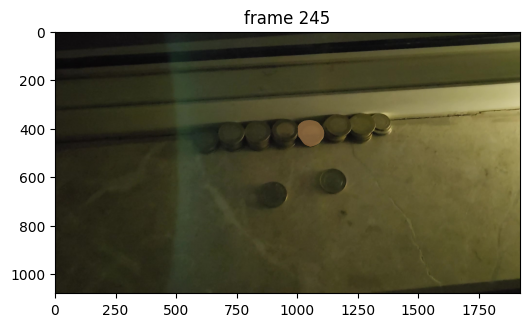

In [22]:
# render the segmentation results every few frames
vis_frame_stride = 40
plt.close("all")
for out_frame_idx in range(5, len(frame_names_dark_1), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(frames_dark_1, frame_names_dark_1[out_frame_idx])))
    for out_obj_id, out_mask in video_segments_dark_1[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)


#### Make video of sam2 annotations

In [27]:
# Example usage:
output_video_path = "sam2_out_dark_1.mp4"
create_video_with_masks(video_dir=frames_dark_1, 
                        frame_names=frame_names_dark_1, 
                        video_segments=video_segments_dark_1, 
                        output_video_path=output_video_path)

Video saved to sam2_out_dark_1.mp4


### dark 1 with neg

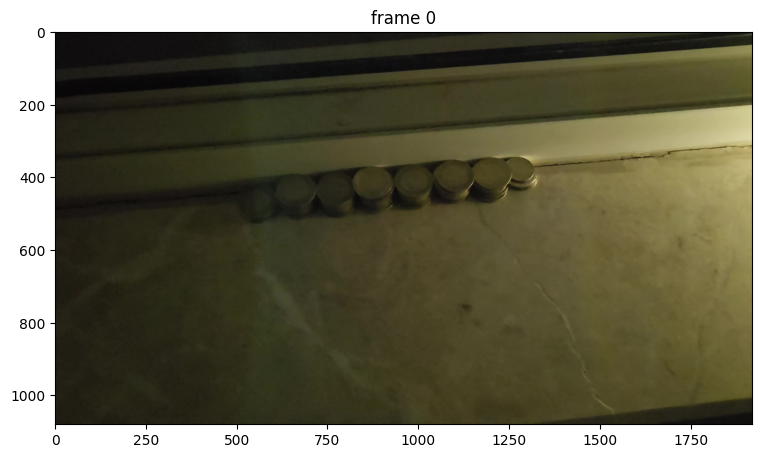

In [15]:
# scan all the JPEG frame names in this directory
frame_names_dark_1_with_neg = [
    p for p in os.listdir(frames_dark_1)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names_dark_1_with_neg.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(frames_dark_1, frame_names_dark_1_with_neg[frame_idx])))

In [16]:
from utils.annotations import dark_1_annot_with_neg

In [17]:
inference_state_dark_1_with_neg = predictor.init_state(video_path=frames_dark_1)

frame loading (JPEG): 100%|██████████| 274/274 [00:15<00:00, 17.90it/s]


In [18]:
video_segments_dark_1_with_neg = feed_promt(frames_dark_1, dark_1_annot_with_neg, predictor, inference_state_dark_1_with_neg, frame_names_dark_1_with_neg)

/tmp/ipykernel_49018/2548460721.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')
/home/rizo/mipt_ccm/sam2/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/home/rizo/mipt_ccm/sam2/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 274/274 [03:06<00:00,  1.47it/s]


In [19]:
# Example usage:
output_video_path = "sam2_out_dark_1_with_neg.mp4"
create_video_with_masks(video_dir=frames_dark_1, 
                        frame_names=frame_names_dark_1_with_neg, 
                        video_segments=video_segments_dark_1_with_neg, 
                        output_video_path=output_video_path)

Video saved to sam2_out_dark_1_with_neg.mp4


### dark 2

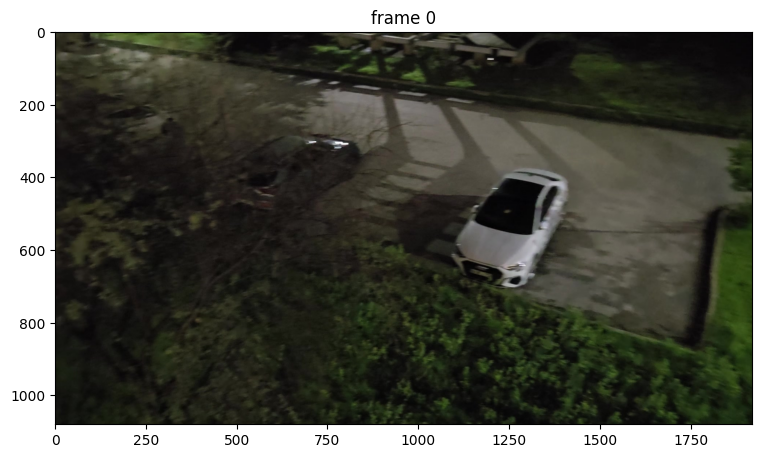

In [14]:
# scan all the JPEG frame names in this directory
frame_names_dark_2 = [
    p for p in os.listdir(frames_dark_2)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names_dark_2.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(frames_dark_2, frame_names_dark_2[frame_idx])))

In [15]:
from utils.annotations import dark_2_annot

In [16]:
inference_state_dark1 = predictor.init_state(video_path=frames_dark_2)

frame loading (JPEG): 100%|██████████| 271/271 [00:12<00:00, 21.57it/s]


In [17]:
video_segments_dark_2 = feed_promt(frames_dark_2, dark_2_annot, predictor, inference_state_dark1, frame_names_dark_2)

/tmp/ipykernel_43829/2548460721.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')
/home/rizo/mipt_ccm/sam2/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/home/rizo/mipt_ccm/sam2/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 271/271 [03:04<00:00,  1.47it/s]


In [18]:
# Example usage:
output_video_path = "sam2_out_dark_2.mp4"
create_video_with_masks(video_dir=frames_dark_2, 
                        frame_names=frame_names_dark_2, 
                        video_segments=video_segments_dark_2, 
                        output_video_path=output_video_path)

Video saved to sam2_out_dark_2.mp4


### light_5

In [15]:
from utils.annotations import light_5_annot

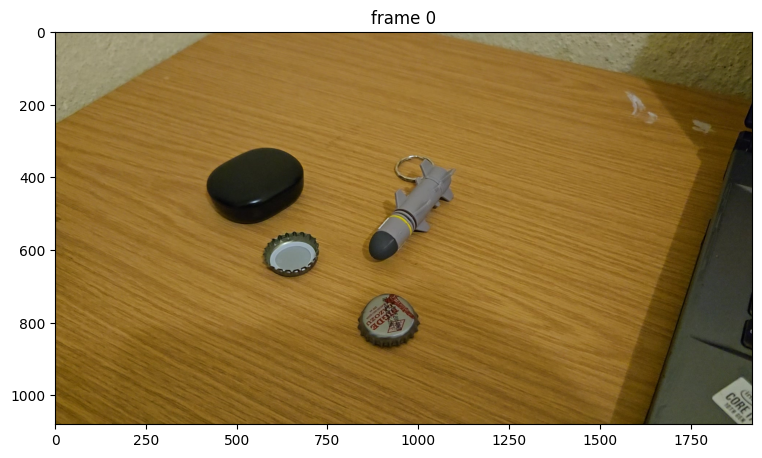

In [16]:
# scan all the JPEG frame names in this directory
frame_names_light_5 = [
    p for p in os.listdir(frames_light_5)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names_light_5.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(frames_light_5, frame_names_light_5[frame_idx])))

In [17]:
inference_state_light_5 = predictor.init_state(video_path=frames_light_5)

frame loading (JPEG): 100%|██████████| 194/194 [00:08<00:00, 21.78it/s]


/home/rizo/mipt_ccm/sam2/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/home/rizo/mipt_ccm/sam2/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


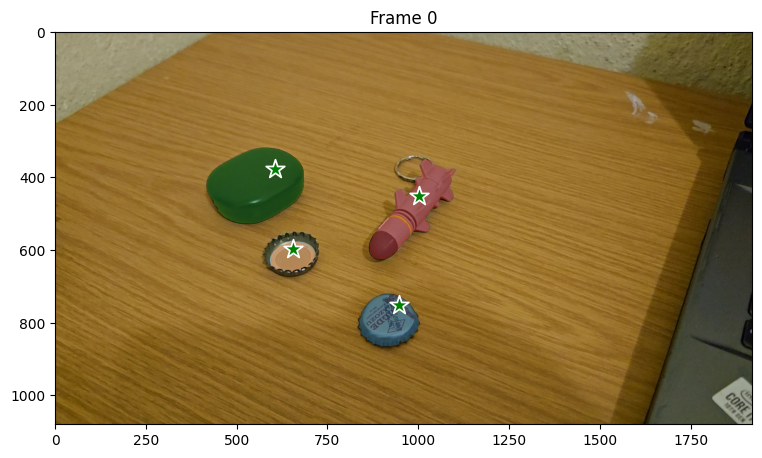

propagate in video: 100%|██████████| 194/194 [03:47<00:00,  1.17s/it]


In [ ]:
video_segments_light_5 = feed_promt(frames_light_5, light_5_annot, predictor, inference_state_light_5, frame_names_light_5)

#### Make video

In [ ]:
# Example usage:
output_video_path = "sam2_out_light_5.mp4"
create_video_with_masks(video_dir=frames_light_5, 
                        frame_names=frame_names_light_5, 
                        video_segments=video_segments_light_5, 
                        output_video_path=output_video_path)

Video saved to sam2_out_light_5.mp4


#### Show some annotated frames

In [ ]:
# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(5, len(frame_names_light_5), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(frames_light_5, frame_names_light_5[out_frame_idx])))
    for out_obj_id, out_mask in video_segments_light_5[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)


### light 4

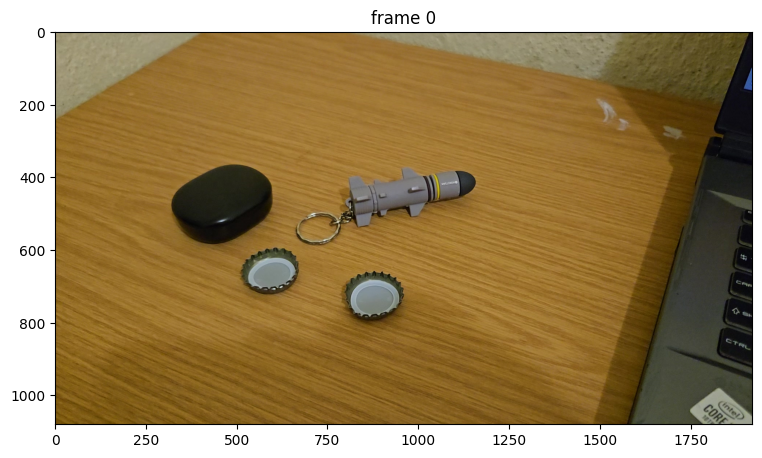

In [14]:
# scan all the JPEG frame names in this directory
frame_names_light_4 = [
    p for p in os.listdir(frames_light_4)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names_light_4.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(frames_light_4, frame_names_light_4[frame_idx])))

In [15]:
inference_state = predictor.init_state(video_path=frames_light_4)

frame loading (JPEG): 100%|██████████| 177/177 [00:08<00:00, 21.83it/s]


In [16]:
from utils.annotations import light_4_annot

In [24]:
video_segments_light_4 = feed_promt(frames_light_4, light_4_annot, predictor, inference_state, frame_names_light_4)

/tmp/ipykernel_34140/1660136527.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')
/home/rizo/mipt_ccm/sam2/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/home/rizo/mipt_ccm/sam2/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video:  63%|██████▎   | 111/177 [02:08<01:16,  1.15s/it]


KeyboardInterrupt: 

#### Make video of light_4

In [22]:
# Example usage:
output_video_path = "sam2_out_light_4.mp4"
create_video_with_masks(video_dir=frames_light_4, 
                        frame_names=frame_names_light_4, 
                        video_segments=video_segments_light_4, 
                        output_video_path=output_video_path)

Video saved to sam2_out_light_4.mp4


#### Show some annotated frames

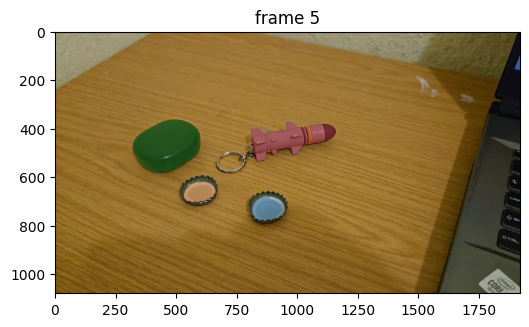

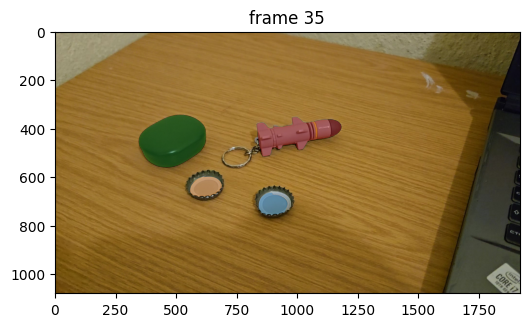

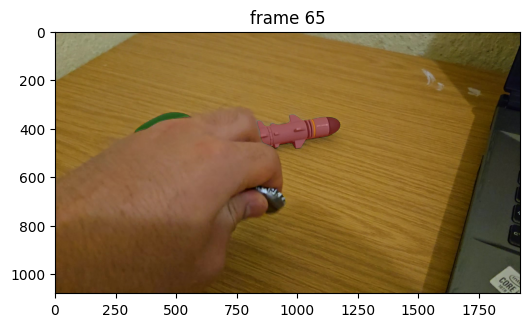

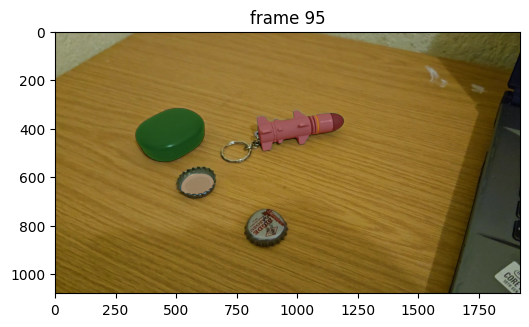

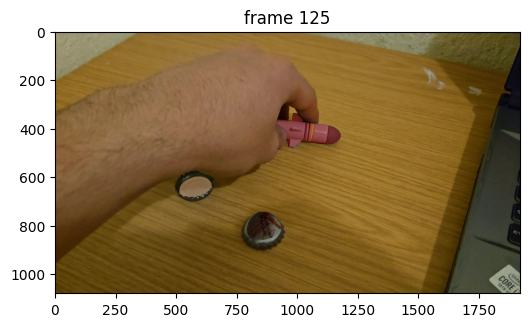

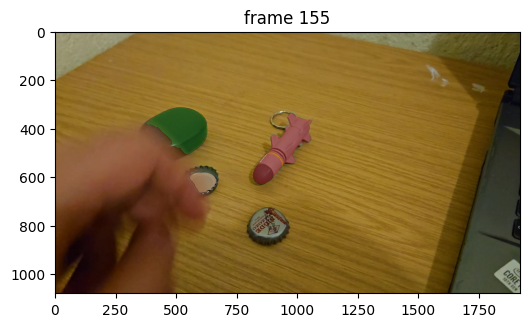

In [19]:
# render the segmentation results every few frames
vis_frame_stride = 30
plt.close("all")
for out_frame_idx in range(5, len(frame_names_light_4), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(frames_light_4, frame_names_light_4[out_frame_idx])))
    for out_obj_id, out_mask in video_segments_light_4[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)


### light 2

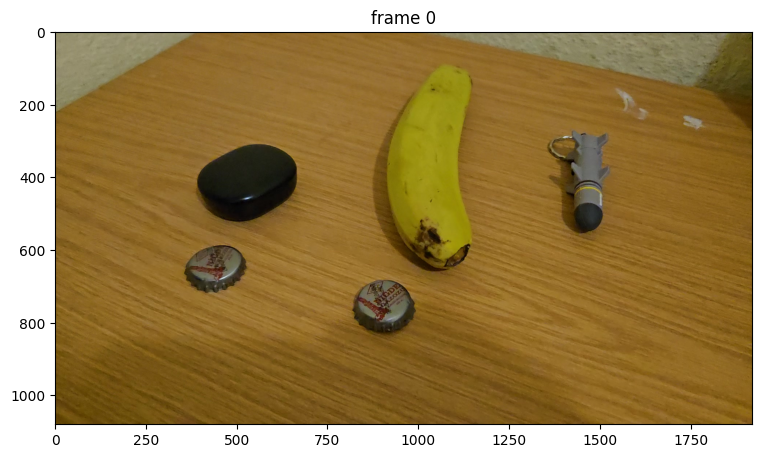

In [14]:
# scan all the JPEG frame names in this directory
frame_names_light_2 = [
    p for p in os.listdir(frames_light_2)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names_light_2.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(frames_light_2, frame_names_light_2[frame_idx])))

In [15]:
from utils.annotations import light_2_annot

In [16]:
inference_state = predictor.init_state(video_path=frames_light_2)

frame loading (JPEG): 100%|██████████| 300/300 [00:14<00:00, 20.98it/s]


/home/rizo/mipt_ccm/sam2/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/home/rizo/mipt_ccm/sam2/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


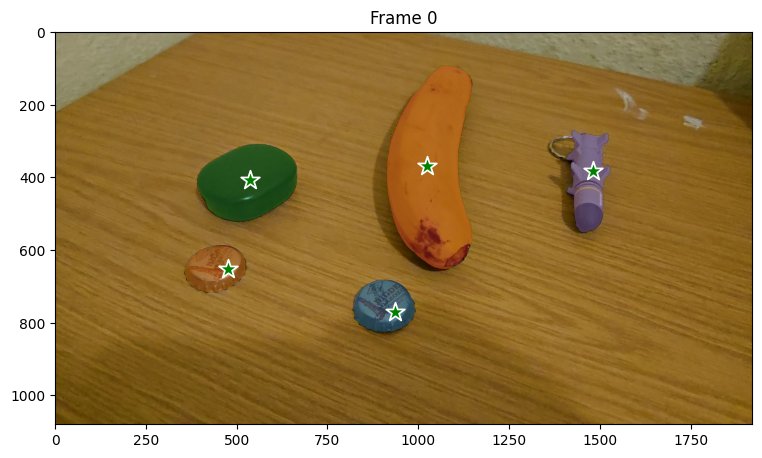

propagate in video:  31%|███▏      | 94/300 [02:12<04:49,  1.40s/it]


OutOfMemoryError: CUDA out of memory. Tried to allocate 450.00 MiB. GPU 0 has a total capacity of 5.80 GiB of which 449.62 MiB is free. Process 3098 has 71.80 MiB memory in use. Including non-PyTorch memory, this process has 5.28 GiB memory in use. Of the allocated memory 4.90 GiB is allocated by PyTorch, and 300.74 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [17]:
video_segments_light_2 = feed_promt(frames_light_2, light_2_annot, predictor, inference_state, frame_names_light_2)

#### Make annotated video

In [ ]:
# Example usage:
output_video_path = "sam2_out_light_2.mp4"
create_video_with_masks(video_dir=frames_light_2, 
                        frame_names=frame_names_light_2, 
                        video_segments=video_segments_light_2, 
                        output_video_path=output_video_path)

### light 3

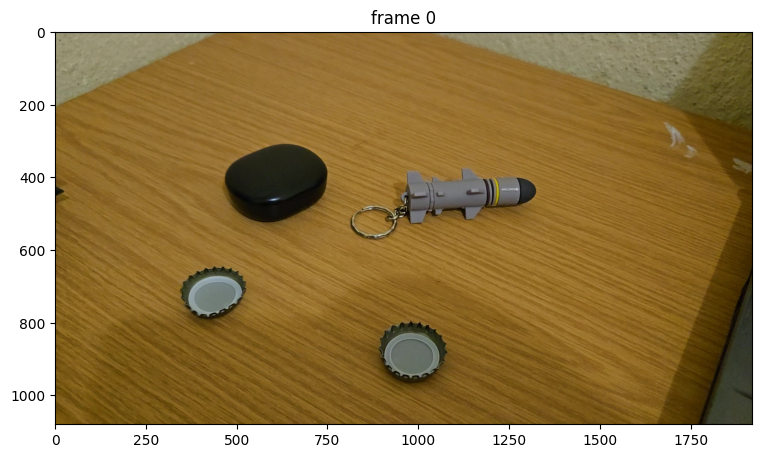

In [14]:
# scan all the JPEG frame names in this directory
frame_names_light_3 = [
    p for p in os.listdir(frames_light_3)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names_light_3.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(frames_light_3, frame_names_light_3[frame_idx])))

In [15]:
from utils.annotations import light_3_annot

In [16]:
inference_state = predictor.init_state(video_path=frames_light_3)

frame loading (JPEG): 100%|██████████| 241/241 [00:10<00:00, 22.43it/s]


In [28]:
video_segments_light_3 = feed_promt(frames_light_3, light_3_annot, predictor, inference_state, frame_names_light_3)

/tmp/ipykernel_16191/959183551.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')
/home/rizo/mipt_ccm/sam2/sam2/sam2/sam2_video_predictor.py:786: UserWarning: cannot import name '_C' from 'sam2' (/home/rizo/mipt_ccm/sam2/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video:   2%|▏         | 6/241 [00:04<02:58,  1.32it/s]


KeyboardInterrupt: 

#### Make annotated video

In [22]:
# Example usage:
output_video_path = "sam2_out_light_3.mp4"
create_video_with_masks(video_dir=frames_light_3, 
                        frame_names=frame_names_light_3, 
                        video_segments=video_segments_light_3, 
                        output_video_path=output_video_path)

TypeError: 'generator' object is not subscriptable

### light 1

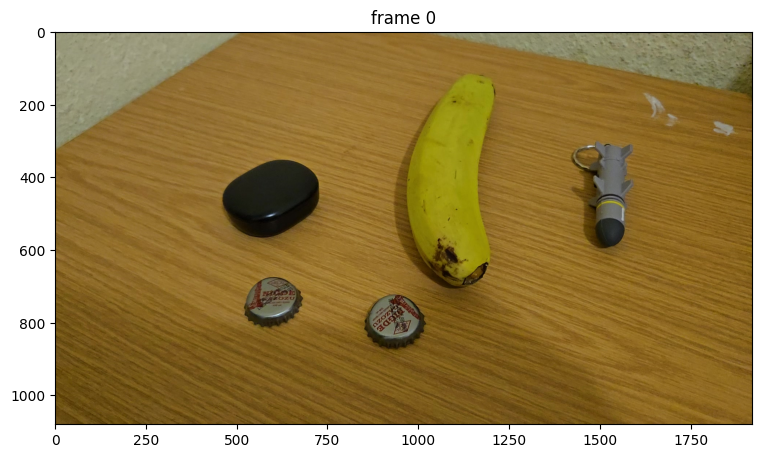

In [19]:
# scan all the JPEG frame names in this directory
frame_names_light_1 = [
    p for p in os.listdir(frames_light_1)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names_light_1.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(frames_light_1, frame_names_light_1[frame_idx])))

In [20]:
from utils.annotations import light_1_annot

In [21]:
inference_state = predictor.init_state(video_path=frames_light_1)

frame loading (JPEG): 100%|██████████| 389/389 [00:19<00:00, 19.73it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 4.56 GiB. GPU 0 has a total capacity of 5.80 GiB of which 1.48 GiB is free. Process 3098 has 71.80 MiB memory in use. Including non-PyTorch memory, this process has 4.23 GiB memory in use. Of the allocated memory 3.95 GiB is allocated by PyTorch, and 197.57 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
video_segments_light_1 = feed_promt(frames_light_1, light_1_annot, predictor, inference_state, frame_names_light_1)

#### Make video

In [ ]:
# Example usage:
output_video_path = "sam2_out_light_1.mp4"
create_video_with_masks(video_dir=frames_light_1, 
                        frame_names=frame_names_light_1, 
                        video_segments=video_segments_light_1, 
                        output_video_path=output_video_path)

### card

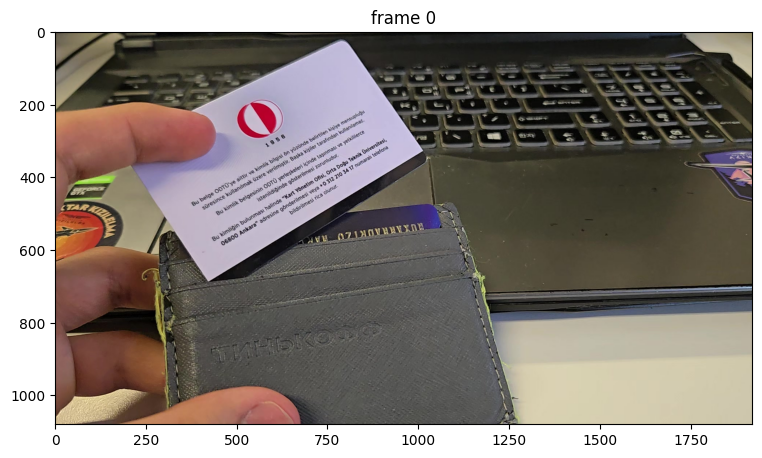

In [14]:
# scan all the JPEG frame names in this directory
frame_names_card = [
    p for p in os.listdir(frames_card)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names_card.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(frames_card, frame_names_card[frame_idx])))

In [15]:
from utils.annotations import card_annot

In [16]:
inference_state = predictor.init_state(video_path=frames_card)

frame loading (JPEG): 100%|██████████| 51/51 [00:02<00:00, 21.31it/s]


In [20]:
video_segments_card = feed_promt(frames_card, card_annot, predictor, inference_state, frame_names_card)

/tmp/ipykernel_40577/2548460721.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20')
propagate in video: 100%|██████████| 51/51 [00:20<00:00,  2.43it/s]


#### make video

In [23]:
# Example usage:
output_video_path = "sam2_out_card.mp4"
create_video_with_masks(video_dir=frames_card, 
                        frame_names=frame_names_card, 
                        video_segments=video_segments_card, 
                        output_video_path=output_video_path)

Video saved to sam2_out_card.mp4
